In [1]:
import sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

Below is just a demo of the features.
Refer to [Models API Reference](https://ajkdrag.github.io/ocrtoolkit/ocrtoolkit/models/arch.html) for details.
As of today, `ocrtoolkit` supports integrations with:
- DocTR
- Ultralytics (yolov8, rtdetr etc)
- PaddleOCR
- Google Cloud Vision

## imports

The prefix `UL` indicates that this model is from `Ultralytics`. 
Similarly, `DOCTR` for `DocTR` and `PPOCR` for `PaddleOCR`
Make sure that you installed the necessary extra dependencies
i.e. using:
```
pip install ocrtoolkit[ultralytics,paddle]
```

In [3]:
from ocrtoolkit.models import UL_RTDETR, PPOCR_SVTR_LCNET, DOCTR_FAST_T

In [4]:
from ocrtoolkit.core import detect, recognize
from ocrtoolkit.datasets import FileDS

/home/ajkdrag/workspace/ocrtoolkit/src/ocrtoolkit/utilities/io_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## loading models

Here we are loading a custom fine-tuned RTDETR model. For actual model training/finetuning follow steps from `Ultralytics` repo. This model is fine-tuned to detect certain regions of text like date, amount, payee name etc from bank cheques.

In [5]:
detection_model = UL_RTDETR(path="../pretrained/best.pt")

2024-03-30 19:25:15.931 | INFO     | ocrtoolkit.wrappers.model:__init__:22 - Loaded model from ../pretrained/best.pt, to cpu


Here we are loading the pretrained PPOCRv4 recognition model

In [6]:
recognition_model = PPOCR_SVTR_LCNET()

2024-03-30 19:25:20.243 | INFO     | ocrtoolkit.utilities.network_utils:download_file:86 - Found /home/ajkdrag/.cache/ppocr/models/en_PP-OCRv4_rec_infer.tar. Skipping download.
2024-03-30 19:25:20.244 | INFO     | ocrtoolkit.utilities.network_utils:download_file:107 - Found /home/ajkdrag/.cache/ppocr/models/en_PP-OCRv4_rec_infer. Skipping untar.
2024-03-30 19:25:20.248 | INFO     | ocrtoolkit.integrations.paddleocr:load:118 - Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir=None, cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir=None, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast

## loading few images for inference

In [7]:
mini_ds = FileDS("../data/public/images/").sample()

  0%|          | 0/237 [00:00<?, ?it/s]

2024-03-30 19:25:23.645 | INFO     | ocrtoolkit.utilities.io_utils:get_files:57 - Found 235 files.


In [8]:
len(mini_ds)

5

## running detection inference

In [9]:
det_results = detect(detection_model, mini_ds, stream=False, verbose=False)

In [10]:
det_results[0]

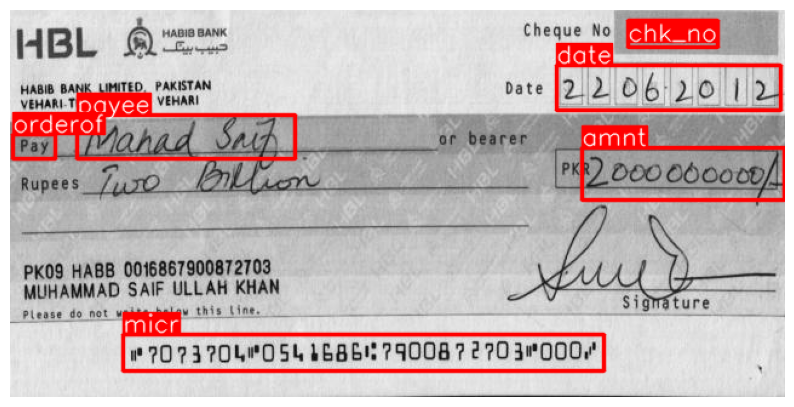

In [11]:
det_results[0].draw(mini_ds, show_label=True)

## running recognition inference

Here we create a `dataset` out of the detection results and we use this dataset for recognition.
For verbosity, one can also run a `for` loop, crop out each detection result, wrap it as an `ImageDS` and call `recognize` on it. Refer [DetectionResults API](https://ajkdrag.github.io/ocrtoolkit/ocrtoolkit/wrappers/detection_results.html#ocrtoolkit.wrappers.detection_results.DetectionResults.get_crops) for corresponding methods

In [12]:
list_det_ds = [det_result.create_ds(mini_ds) for det_result in det_results]

In [13]:
list_det_ds[0]

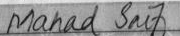

In [14]:
list_det_ds[0][0]

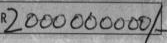

In [15]:
list_det_ds[0][1]

In [16]:
recognition_results = [recognize(recognition_model, ds, verbose=False, stream=False)
                       for ds in list_det_ds]

Visualizing recognition results for the first image, i.e index 0

In [17]:
first_image_results = recognition_results[0]
first_image_ds = list_det_ds[0]

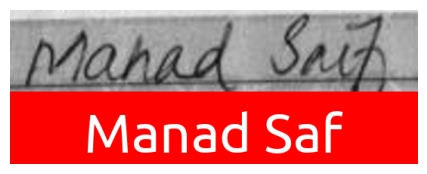

In [18]:
first_image_results[0].draw(first_image_ds)

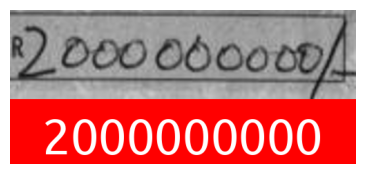

In [19]:
first_image_results[1].draw(first_image_ds)

In [27]:
kwargs = {
    "symmetric_pad": True,
    "preserve_aspect_ratio": True
}

text_detection_model = DOCTR_FAST_T(path="/home/ajkdrag/.cache/doctr/models/fast_tiny-1acac421.pt",
                                       **kwargs)

2024-03-30 19:27:31.621 | INFO     | ocrtoolkit.wrappers.model:__init__:22 - Loaded model from /home/ajkdrag/.cache/doctr/models/fast_tiny-1acac421.pt, to cpu


In [28]:
text_det_results = detect(text_detection_model, mini_ds, stream=False, verbose=False)

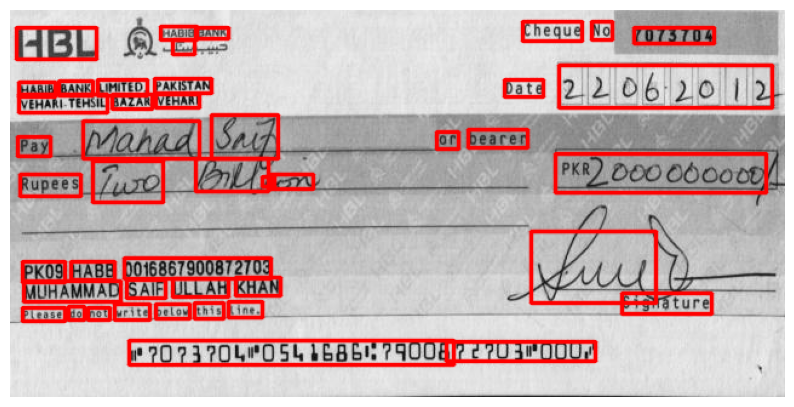

In [29]:
text_det_results[0].draw(mini_ds)

In [30]:
list_text_det_ds = [det_result.create_ds(mini_ds) for det_result in text_det_results]

In [31]:
recognition_results = [recognize(recognition_model, ds, verbose=False, stream=False)
                       for ds in list_text_det_ds]

In [32]:
first_image_results = recognition_results[0]
first_image_ds = list_text_det_ds[0]

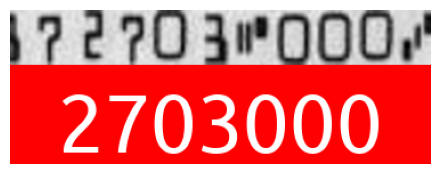

In [33]:
first_image_results[0].draw(first_image_ds)

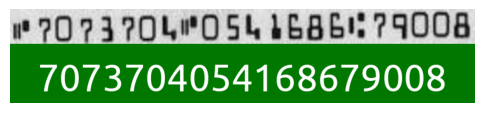

In [34]:
first_image_results[1].draw(first_image_ds, color=(0,120,0))